In [89]:
!pip install langchain_google_genai
!pip install langchain_core
!pip install --upgrade langgraph


In [90]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
)

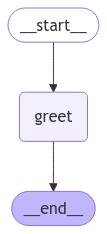

In [91]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class GreetingState(MessagesState):
  """
  This state schema can carry the user's message
  and the final greeting response.
  """
  user_message: str
  greeting_response: str

def greet(state: GreetingState):
  """
  Respond to a user greeting in a friendly way.
  """
  greeting_response = "Hello there! How can I help you today?"
  return {"greeting_response": greeting_response}

sub_graph_builder = StateGraph(GreetingState)
sub_graph_builder.add_node("greet", greet)
sub_graph_builder.add_edge(START, "greet")
sub_graph_builder.add_edge("greet", END)

greeting_subgraph = sub_graph_builder.compile()

display(Image(greeting_subgraph.get_graph(xray=True).draw_mermaid_png()))


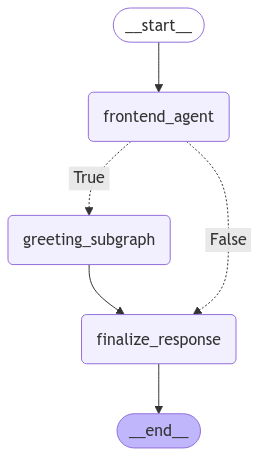

In [125]:
# Define parent graph
from typing import Optional
from langchain_core.messages import HumanMessage, AIMessage

class FrontendState(MessagesState):
  """
  State for the front-end agent.
  We store:
  - user_message: text from the user
  - final_response: the front-end's consolidated reply
  - (Optional) subgraph output if we call the greeting subagent

  """
  user_message: str =""
  final_response: str = "I only handle greetings right now. Try saying 'Hello'!"
  is_greeting_route: bool = False
  greeting_response: Optional[str] = None

def frontend_agent(state: FrontendState):
  """
  Uses an LLM to decide if the user’s input is a greeting.
  We'll do a simple prompt telling the LLM to answer only 'Yes' or 'No'.
  """
  prompt = [HumanMessage(content=f"""Determine if the following message is a greeting.
  Output exactly "Yes" or "No" (nothing else).

  User Message: {state['user_message']}
  """)]
  llm_answer = llm(prompt).content.strip().lower()

  if "yes" in llm_answer:
    state["is_greeting_route"] = True
  else:
    state["is_greeting_route"] = False

  return state



def routing_function(state: FrontendState):
  if state["is_greeting_route"] == True:
    return state["is_greeting_route"]
  else:
    return state["is_greeting_route"]


def finalize_response(state: FrontendState):
  """
  Once we come back from the subgraph with a greeting, we store it
  into final_response (the aggregator's consolidated result).
  """
  if state.get('greeting_response'):
    state['final_response'] = state['greeting_response']
  else:
    state["final_response"] = state.get('final_response', "I only handle greetings right now. Try saying 'Hello!'")
  return state

frontend_builder = StateGraph(FrontendState)
frontend_builder.add_node("frontend_agent", frontend_agent)
frontend_builder.add_node("greeting_subgraph", greeting_subgraph)
frontend_builder.add_node("finalize_response", finalize_response)

frontend_builder.add_edge(START, "frontend_agent")
frontend_builder.add_conditional_edges("frontend_agent", routing_function, {True: "greeting_subgraph", False: "finalize_response" })
frontend_builder.add_edge("greeting_subgraph", "finalize_response")
frontend_builder.add_edge("finalize_response", END)


frontend_graph = frontend_builder.compile()

display(Image(frontend_graph.get_graph(xray=False).draw_mermaid_png()))

In [93]:
from google.colab import userdata
# import google.generativeai as genai

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [129]:

result = frontend_graph.invoke({"user_message": "wher is india"})
print(result["final_response"])


I only handle greetings right now. Try saying 'Hello!'


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
)

tools = [greet]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content=
 (
  """
  You are a helpful assistant.
  You have a Python function named 'greet' that you can call to handle user greetings.
  If the user says something not greeting-related, still call 'greet' to show a fallback.
  """
  )
)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage

def assistant(state: MessagesState):
  """
    The node that calls the LLM (which can decide to use greet()).
  """
  all_msgs = [sys_msg] + state['messages']
  response_msg = llm_with_tools.invoke(all_msgs)
  return {"messages": [response_msg]}

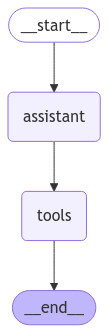

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

tool_node = ToolNode(tools)

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="good morning")]
result = graph.invoke({"messages": messages})
for m in result["messages"]:
  m.pretty_print()


================================ Human Message =================================

good morning
================================== Ai Message ==================================
Tool Calls:
  greet (96b65dd6-d1c1-4e76-82de-478272370ed8)
 Call ID: 96b65dd6-d1c1-4e76-82de-478272370ed8
  Args:
    user_input: good morning
================================= Tool Message =================================
Name: greet

Hello there! How can I help you today?
